### 1.按公司文件分开训练模型

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.029957849191318095
Epoch 2/100, Validation Loss: 0.02729670303335912
Epoch 3/100, Validation Loss: 0.027341094550112605
Epoch 4/100, Validation Loss: 0.027514697695282142
Epoch 5/100, Validation Loss: 0.023140304354609738
Epoch 6/100, Validation Loss: 0.02458254372517408
Epoch 7/100, Validation Loss: 0.027064121249590962
Epoch 8/100, Validation Loss: 0.02341348461439492
Epoch 9/100, Validation Loss: 0.02361598979471855
Epoch 10/100, Validation Loss: 0.022085997433414762
Epoch 11/100, Validation Loss: 0.022670815554513057
Epoch 12/100, Validation Loss: 0.02318629013820433
Epoch 13/100, Validation Loss: 0.020937339478159244
Epoch 14/100, Validation Loss: 0.022822862163081135
Epoch 15/100, Validation Loss: 0.02086036122390922
Epoch 16/100, Validation Loss: 0.02544364166564085
Epoch 17/100, Validation Loss: 0.021516923386026437
Epoch 18/100, Validation Loss: 0.020727217341707627
Epoch 19/100, Validation Loss: 0.022568933639517973
Epoch 20/10

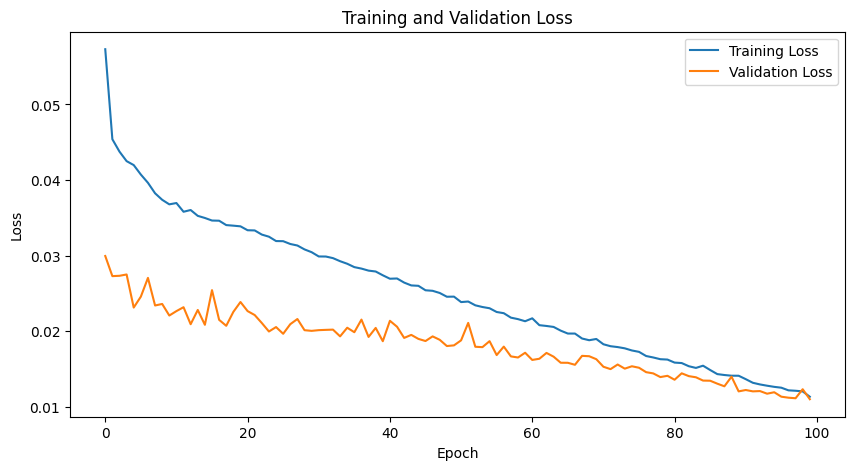

000001.SZ_平安银行_all2.xlsx: MAE=0.6865143775939941, MSE=0.47627726197242737, R2=-94.8948441568368
000002.SZ_万科A_all2.xlsx: MAE=0.5527634620666504, MSE=0.3578948974609375, R2=-5.893477484954307
000063.SZ_中兴通讯_all2.xlsx: MAE=0.4148968756198883, MSE=0.18101871013641357, R2=-19.385851008716955
000100.SZ_TCL科技_all2.xlsx: MAE=0.6331471800804138, MSE=0.4190150201320648, R2=-22.119152268871513
000157.SZ_中联重科_all2.xlsx: MAE=0.6062095165252686, MSE=0.38458943367004395, R2=-21.39838585639789
000166.SZ_申万宏源_all2.xlsx: MAE=0.5248320698738098, MSE=0.2921994626522064, R2=-16.443895678011675
000301.SZ_东方盛虹_all2.xlsx: MAE=0.6202179789543152, MSE=0.40079209208488464, R2=-23.951981756366774
000333.SZ_美的集团_all2.xlsx: MAE=0.6778576374053955, MSE=0.4785280227661133, R2=-23.968428166782385
000338.SZ_潍柴动力_all2.xlsx: MAE=0.9255452156066895, MSE=0.8577046394348145, R2=-815.9963550119344
000408.SZ_藏格矿业_all2.xlsx: MAE=0.4593307077884674, MSE=0.22710299491882324, R2=-13.197688140317302
000425.SZ_徐工机械_all2.xlsx: MAE=

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    # model.eval()
    # test_loss = 0
    # test_predictions = []
    # test_targets = []
    # with torch.no_grad():
    #     for inputs, targets in test_loader:
    #         inputs, targets = inputs.to(device), targets.to(device)
    #         outputs = model(inputs)
    #         test_loss += criterion(outputs, targets).item()
    #         test_predictions.extend(outputs.cpu().numpy().flatten())
    #         test_targets.extend(targets.cpu().numpy().flatten())
    # test_loss /= len(test_loader)
    # mae = mean_absolute_error(test_targets, test_predictions)
    # mse = mean_squared_error(test_targets, test_predictions)
    # r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses

def test_model(model, test_loader, device):
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae,mse,r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    input_size = 8  
    hidden_size = 50
    num_layers = 2
    output_size = 1


    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0") 
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []


    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []


    file_list = []


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)


    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)
    test_x = torch.cat(all_test_x, dim=0)
    test_y = torch.cat(all_test_y, dim=0)


    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)
    test_dataset = TensorDataset(test_x, test_y)


    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)


    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    train_losses, val_losses = train_and_evaluate_model(model, train_loader, val_loader,  num_epochs, learning_rate, device)
    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            train_dataset = TensorDataset(train_x, train_y)
            val_dataset = TensorDataset(val_x, val_y)
            test_dataset = TensorDataset(test_x, test_y)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
            mae, mse, r2 = test_model(model, test_loader,device)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)


    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    for i, file in enumerate(file_list):
        if i < len(all_mae):
            print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


    model_save_path = 'E:/2412毕业论文/0104模型构建/模型文件/best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.031198223501863614
Epoch 2/100, Validation Loss: 0.02787285305979386
Epoch 3/100, Validation Loss: 0.027571230575862065
Epoch 4/100, Validation Loss: 0.024971420863564586
Epoch 5/100, Validation Loss: 0.024531503693318704
Epoch 6/100, Validation Loss: 0.024217636167058642
Epoch 7/100, Validation Loss: 0.022238320277505358
Epoch 8/100, Validation Loss: 0.02366573321567455
Epoch 9/100, Validation Loss: 0.023914463542611668
Epoch 10/100, Validation Loss: 0.022200233971988653
Epoch 11/100, Validation Loss: 0.022017116461631278
Epoch 12/100, Validation Loss: 0.02372357901185751
Epoch 13/100, Validation Loss: 0.022797065760782907
Epoch 14/100, Validation Loss: 0.022199834159142534
Epoch 15/100, Validation Loss: 0.021326119513054128
Epoch 16/100, Validation Loss: 0.024652247330252553
Epoch 17/100, Validation Loss: 0.020460819982936685
Epoch 18/100, Validation Loss: 0.020975193913868616
Epoch 19/100, Validation Loss: 0.021079815242072225
Epoch 2

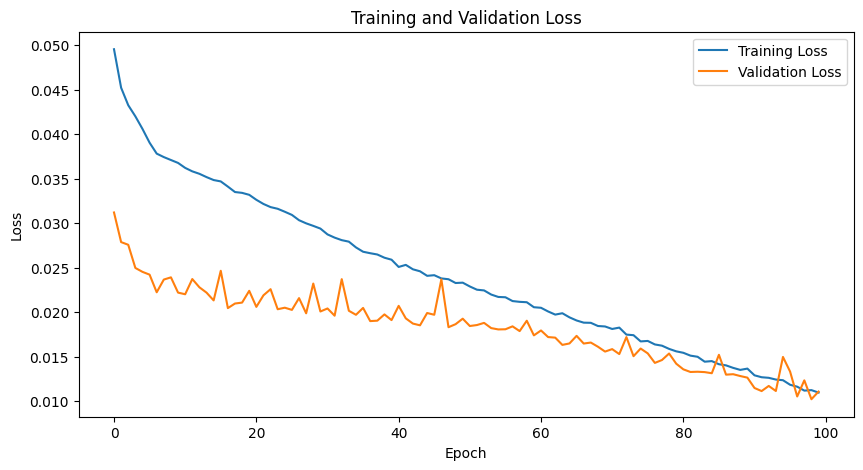

000001.SZ_平安银行_all2.xlsx: MAE=0.5083891749382019, MSE=0.263437420129776, R2=-52.0411470292837
000002.SZ_万科A_all2.xlsx: MAE=0.5055451393127441, MSE=0.3071952760219574, R2=-4.916942884564479
000063.SZ_中兴通讯_all2.xlsx: MAE=0.6408219337463379, MSE=0.41956451535224915, R2=-46.25025556309826
000100.SZ_TCL科技_all2.xlsx: MAE=0.5584190487861633, MSE=0.32985061407089233, R2=-17.19950517156348
000157.SZ_中联重科_all2.xlsx: MAE=0.5641593337059021, MSE=0.33534741401672363, R2=-18.530544758321245
000166.SZ_申万宏源_all2.xlsx: MAE=0.5224429965019226, MSE=0.28974035382270813, R2=-16.297091932861058
000301.SZ_东方盛虹_all2.xlsx: MAE=0.631749153137207, MSE=0.4151144027709961, R2=-24.843640956830253
000333.SZ_美的集团_all2.xlsx: MAE=0.5272539258003235, MSE=0.2971014678478241, R2=-14.502031979379998
000338.SZ_潍柴动力_all2.xlsx: MAE=0.8106668591499329, MSE=0.6582340598106384, R2=-625.9930592680254
000408.SZ_藏格矿业_all2.xlsx: MAE=0.6090250611305237, MSE=0.3869245946407318, R2=-23.189177353505507
000425.SZ_徐工机械_all2.xlsx: MAE=0.78

RuntimeError: Parent directory E:/2412毕业论文/0104模型构建/模型文件 does not exist.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []

    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    # model.eval()
    # test_loss = 0
    # test_predictions = []
    # test_targets = []
    # with torch.no_grad():
    #     for inputs, targets in test_loader:
    #         inputs, targets = inputs.to(device), targets.to(device)
    #         outputs = model(inputs)
    #         test_loss += criterion(outputs, targets).item()
    #         test_predictions.extend(outputs.cpu().numpy().flatten())
    #         test_targets.extend(targets.cpu().numpy().flatten())
    # test_loss /= len(test_loader)
    # mae = mean_absolute_error(test_targets, test_predictions)
    # mse = mean_squared_error(test_targets, test_predictions)
    # r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses

def test_model(model, test_loader, device):
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae,mse,r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    input_size = 8  
    hidden_size = 50
    num_layers = 2
    output_size = 1



    if torch.cuda.is_available():
        device = torch.device("cuda:0")  
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []


    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []


    file_list = []


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(test_x)
            all_test_y.append(test_y)


    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)
    test_x = torch.cat(all_test_x, dim=0)
    test_y = torch.cat(all_test_y, dim=0)


    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)
    test_dataset = TensorDataset(test_x, test_y)


    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)


    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    train_losses, val_losses = train_and_evaluate_model(model, train_loader, val_loader,  num_epochs, learning_rate, device)
    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            train_dataset = TensorDataset(train_x, train_y)
            val_dataset = TensorDataset(val_x, val_y)
            test_dataset = TensorDataset(test_x, test_y)

            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
            mae, mse, r2 = test_model(model, test_loader,device)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)


    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    for i, file in enumerate(file_list):
        if i < len(all_mae):
            print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')



    model_save_path = 'E:/2412毕业论文/0104模型构建/模型文件/best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()